In [1]:
import pandas as pd
import numpy as np

X_train = pd.read_csv('../../data/cve_2018-2020_X_train.csv')
y_train = pd.read_csv('../../data/cve_2018-2020_y_train.csv')

X_test = pd.read_csv('../../data/cve_2018-2020_X_test.csv')
y_test = pd.read_csv('../../data/cve_2018-2020_y_test.csv')

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

print(y_train['cvssV3_confidentialityImpact'].value_counts(dropna=False) / y_train.shape[0])
print(y_test['cvssV3_confidentialityImpact'].value_counts(dropna=False) / y_test.shape[0])
print(X_train.info())
print(y_train.info())

(22963, 2)
(22963, 2)
(22963, 16)
(22963, 16)
HIGH    0.589949
NONE    0.212516
LOW     0.197535
Name: cvssV3_confidentialityImpact, dtype: float64
HIGH    0.588599
NONE    0.215477
LOW     0.195924
Name: cvssV3_confidentialityImpact, dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22963 entries, 0 to 22962
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   CVE_ID       22963 non-null  object
 1   Description  22963 non-null  object
dtypes: object(2)
memory usage: 358.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22963 entries, 0 to 22962
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   cvssV3_vectorString           22963 non-null  object 
 1   cvssV3_attackVector           22963 non-null  object 
 2   cvssV3_attackComplexity       22963 non-null  object 
 3   cvssV3_privilegesRequi

**Training Hugging Face Bert-Small model to classify CVE vulnerability descriptions according to their "confidentiality Impact"**

**Confidentiality Impact**: This metric measures the impact to the confidentiality of the information resources managed by a software component due to a successfully exploited vulnerability. Confidentiality refers to limiting information access and disclosure to only authorized users, as well as preventing access by, or disclosure to, unauthorized ones. The Base Score is greatest when the loss to the impacted component is highest. 

In [3]:
label_column_name = "cvssV3_confidentialityImpact"
train_labels = y_train.loc[:, label_column_name]
test_labels = y_test.loc[:, label_column_name]


from sklearn.preprocessing import LabelEncoder
import pickle

le = LabelEncoder()
le.fit(train_labels)
print(le.classes_)

with open("confidentiality_impact_label.txt", "wb") as f:
    pickle.dump(le.classes_, f)

NUM_CLASSES = len(le.classes_)
print(NUM_CLASSES)

encoded_train_labels = le.transform(train_labels)
encoded_test_labels = le.transform(test_labels)

print(train_labels[:10], encoded_train_labels[:10])
print(len(X_train), len(train_labels), len(X_test), len(test_labels))

['HIGH' 'LOW' 'NONE']
3
0    HIGH
1    HIGH
2    HIGH
3     LOW
4    NONE
5    NONE
6    NONE
7    HIGH
8    HIGH
9    HIGH
Name: cvssV3_confidentialityImpact, dtype: object [0 0 0 1 2 2 2 0 0 0]
22963 22963 22963 22963


In [3]:
X_train.loc[:,"Description"].tolist()

['A vulnerability in Cisco IOS ROM Monitor (ROMMON) Software for Cisco Catalyst 6800 Series Switches could allow an unauthenticated, local attacker to bypass Cisco Secure Boot validation checks and load a compromised software image on an affected device. The vulnerability is due to the presence of a hidden command in the affected software. An attacker could exploit this vulnerability by connecting to an affected device via the console, forcing the device into ROMMON mode, and writing a malicious pattern to a specific memory address on the device. A successful exploit could allow the attacker to bypass signature validation checks by Cisco Secure Boot technology and load a compromised software image on the affected device. A compromised software image is any software image that has not been digitally signed by Cisco.',
 'The official haproxy docker images before 1.8.18-alpine (Alpine specific) contain a blank password for a root user. System using the haproxy docker container deployed by

In [3]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained('prajjwal1/bert-small')

In [4]:
train_encodings = tokenizer(X_train.loc[:,"Description"].tolist(), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(X_test.loc[:,"Description"].tolist(), truncation=True, padding=True, max_length=128)

In [5]:
import torch

class CVEDataset(torch.utils.data.Dataset):
    def __init__(self, X, encodings, labels, encoded_labels):
        self.cve_id = X.loc[:,"CVE_ID"].tolist()
        self.texts = X.loc[:,"Description"].tolist()
        self.encodings = encodings
        self.labels = labels.tolist()
        self.encoded_labels = encoded_labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['text_labels'] = self.labels[idx]
        item['encoded_labels'] = torch.tensor(self.encoded_labels[idx])
        item['CVE_ID'] = self.cve_id[idx]
        item['vulnerability_description'] = self.texts[idx]
        
        return item

    def __len__(self):
        return len(self.labels)


In [6]:
train_dataset = CVEDataset(X_train, train_encodings, train_labels, encoded_train_labels)
test_dataset = CVEDataset(X_test, test_encodings, test_labels, encoded_test_labels)

In [7]:
train_dataset[0]

{'input_ids': tensor([  101,  1037, 18130,  1999, 26408, 16380, 17083,  8080,  1006, 17083,
          8202,  1007,  4007,  2005, 26408, 16771, 23944,  2692,  2186, 15924,
          2071,  3499,  2019, 14477, 14317,  4765, 17872,  1010,  2334, 17346,
          2000, 11826, 26408,  5851,  9573, 27354, 14148,  1998,  7170,  1037,
         20419,  4007,  3746,  2006,  2019,  5360,  5080,  1012,  1996, 18130,
          2003,  2349,  2000,  1996,  3739,  1997,  1037,  5023,  3094,  1999,
          1996,  5360,  4007,  1012,  2019, 17346,  2071, 18077,  2023, 18130,
          2011,  7176,  2000,  2019,  5360,  5080,  3081,  1996, 10122,  1010,
          6932,  1996,  5080,  2046, 17083,  8202,  5549,  1010,  1998,  3015,
          1037, 24391,  5418,  2000,  1037,  3563,  3638,  4769,  2006,  1996,
          5080,  1012,  1037,  3144, 18077,  2071,  3499,  1996, 17346,  2000,
         11826,  8085, 27354, 14148,  2011, 26408,  5851,  9573,  2974,  1998,
          7170,  1037, 20419,  4007,  3

In [8]:
train_dataset[0]['input_ids']

tensor([  101,  1037, 18130,  1999, 26408, 16380, 17083,  8080,  1006, 17083,
         8202,  1007,  4007,  2005, 26408, 16771, 23944,  2692,  2186, 15924,
         2071,  3499,  2019, 14477, 14317,  4765, 17872,  1010,  2334, 17346,
         2000, 11826, 26408,  5851,  9573, 27354, 14148,  1998,  7170,  1037,
        20419,  4007,  3746,  2006,  2019,  5360,  5080,  1012,  1996, 18130,
         2003,  2349,  2000,  1996,  3739,  1997,  1037,  5023,  3094,  1999,
         1996,  5360,  4007,  1012,  2019, 17346,  2071, 18077,  2023, 18130,
         2011,  7176,  2000,  2019,  5360,  5080,  3081,  1996, 10122,  1010,
         6932,  1996,  5080,  2046, 17083,  8202,  5549,  1010,  1998,  3015,
         1037, 24391,  5418,  2000,  1037,  3563,  3638,  4769,  2006,  1996,
         5080,  1012,  1037,  3144, 18077,  2071,  3499,  1996, 17346,  2000,
        11826,  8085, 27354, 14148,  2011, 26408,  5851,  9573,  2974,  1998,
         7170,  1037, 20419,  4007,  3746,  2006,  1996,   102])

In [9]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=16)
next(iter(train_loader))

{'input_ids': tensor([[  101,  1037, 18130,  ...,  2006,  1996,   102],
         [  101,  1996,  2880,  ...,     0,     0,     0],
         [  101,  3768,  1997,  ...,     0,     0,     0],
         ...,
         [  101, 19512, 27885,  ...,     0,     0,     0],
         [  101,  2043,  9798,  ...,     0,     0,     0],
         [  101, 20647,  2102,  ...,     0,     0,     0]]),
 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'text_labels': ['HIGH',
  'HIGH',
  'HIGH',
  'LOW',
  'NONE',
  'NONE',
  'NONE',
  'HIGH',
  'HIGH',
  'HIGH',
  'LOW',
  'LOW

In [10]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained('prajjwal1/bert-small', num_labels=NUM_CLASSES)
model

Some weights of the model checkpoint at prajjwal1/bert-small were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initi

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 512, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=512, out_features=512, bias=True)
              (key): Linear(in_features=512, out_features=512, bias=True)
              (value): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=512, out_features=512, bias=True)
              (LayerNorm): LayerNorm((512,), eps=1e-12, element

In [11]:
for param in model.base_model.parameters():
    param.requires_grad = False
    
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

classifier.weight tensor([[ 0.0123,  0.0093,  0.0006,  ...,  0.0207,  0.0095, -0.0438],
        [ 0.0243, -0.0394,  0.0113,  ...,  0.0079,  0.0159, -0.0120],
        [-0.0187, -0.0174, -0.0427,  ..., -0.0026, -0.0015, -0.0040]])
classifier.bias tensor([0., 0., 0.])


In [12]:
from torch.utils.data import DataLoader
from transformers import AdamW
import torch.nn.functional as F

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

optim = AdamW(model.parameters(), lr=5e-5)

training_loss_batch = []
training_loss_epoch = []

for epoch in range(3):
    model.train()
    training_loss = 0
    num_correct = 0 
    num_examples = 0
    for batch in train_loader:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['encoded_labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        loss.backward()
        optim.step()
        training_loss_batch.append(loss.data.item())
        training_loss += loss.data.item() * input_ids.size(0)
        correct = torch.eq(torch.max(F.softmax(outputs.logits, dim=1), dim=1)[1], labels)
        num_correct += torch.sum(correct).item()
        num_examples += correct.shape[0]
    training_loss /= len(train_loader.dataset)
    training_loss_epoch.append(training_loss)
    
    print('Epoch: {}, Training Loss: {}, Training Accuracy = {}'.format(epoch, training_loss, num_correct / num_examples))

  

Epoch: 0, Training Loss: 0.9410449083048785, Training Accuracy = 0.5899490484692766
Epoch: 1, Training Loss: 0.9040167390773278, Training Accuracy = 0.5929538823324478
Epoch: 2, Training Loss: 0.8846924932208703, Training Accuracy = 0.5994861298610809


In [13]:
for param in model.base_model.parameters():
    param.requires_grad = True
    
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

bert.embeddings.word_embeddings.weight tensor([[ 0.0770, -0.1024,  0.0109,  ...,  0.0265,  0.0527, -0.0099],
        [-0.0062, -0.0448,  0.0068,  ...,  0.0460,  0.0177, -0.0487],
        [-0.0014, -0.0184,  0.0207,  ...,  0.0936,  0.0561, -0.0690],
        ...,
        [-0.0539, -0.0298,  0.0711,  ...,  0.0057,  0.0172, -0.0437],
        [ 0.0446, -0.0571,  0.0028,  ..., -0.0138,  0.0534, -0.0741],
        [ 0.0798,  0.0307, -0.0254,  ...,  0.0389,  0.0417, -0.0208]])
bert.embeddings.position_embeddings.weight tensor([[-2.2368e-03, -1.6215e-02, -5.7656e-03,  ..., -8.1258e-02,
         -1.8137e-02,  1.0507e-03],
        [-1.4434e-02, -9.5276e-03, -3.3733e-04,  ...,  2.2632e-02,
         -2.4823e-02, -2.0542e-02],
        [-1.3487e-02, -6.8095e-05,  7.1685e-03,  ...,  4.7153e-03,
         -1.9992e-03,  6.1711e-03],
        ...,
        [ 2.4908e-02, -1.1784e-03, -9.2854e-03,  ...,  1.1964e-03,
         -1.9798e-02,  4.2636e-03],
        [ 2.8236e-02, -1.1161e-02,  1.2986e-02,  ..., -1.31

In [14]:
from torch.utils.data import DataLoader
from transformers import AdamW
import torch.nn.functional as F

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

optim = AdamW(model.parameters(), lr=5e-5)

training_loss_batch = []
training_loss_epoch = []

for epoch in range(3):
    model.train()
    training_loss = 0
    num_correct = 0 
    num_examples = 0
    for batch in train_loader:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['encoded_labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        loss.backward()
        optim.step()
        training_loss_batch.append(loss.data.item())
        training_loss += loss.data.item() * input_ids.size(0)
        correct = torch.eq(torch.max(F.softmax(outputs.logits, dim=1), dim=1)[1], labels)
        num_correct += torch.sum(correct).item()
        num_examples += correct.shape[0]
    training_loss /= len(train_loader.dataset)
    training_loss_epoch.append(training_loss)
    
    print('Epoch: {}, Training Loss: {}, Training Accuracy = {}'.format(epoch, training_loss, num_correct / num_examples))

  

Epoch: 0, Training Loss: 0.4372683233474695, Training Accuracy = 0.8323825284152767
Epoch: 1, Training Loss: 0.3178134093766223, Training Accuracy = 0.8838130906240473
Epoch: 2, Training Loss: 0.24828608779483508, Training Accuracy = 0.9114662718285939


In [16]:
#model.save_pretrained('./bert-small-vulnerability_confidentiality_impact-classification')

In [17]:
test_loader = DataLoader(test_dataset, batch_size=16)

model.eval()
num_correct = 0 
num_examples = 0
test_loss = 0
for batch in test_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['encoded_labels'].to(device)
    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs[0]
    test_loss += loss.data.item() * input_ids.size(0)
    correct = torch.eq(torch.max(F.softmax(outputs.logits, dim=1), dim=1)[1], labels)
    num_correct += torch.sum(correct).item()
    num_examples += correct.shape[0]
test_loss /= len(test_loader.dataset)

        
print('Test Loss: {}, Test Accuracy = {}'.format(test_loss, num_correct / num_examples))

Test Loss: 0.3623727338125506, Test Accuracy = 0.8704437573487784


**Save the predictions obtained on the test set for further analysis**

In [18]:
import torch
from transformers import BertForSequenceClassification
from torch.utils.data import DataLoader
import torch.nn.functional as F

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = BertForSequenceClassification.from_pretrained('./bert-small-vulnerability_confidentiality_impact-classification')
model.eval()

test_loader = DataLoader(test_dataset, batch_size=16)


num_correct = 0 
num_examples = 0
test_loss = 0
predicted_labels_list = []
predicted_labels_score_list = []
for batch in test_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['encoded_labels'].to(device)
    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs[0]
    test_loss += loss.data.item() * input_ids.size(0)
    predicted_labels = torch.max(F.softmax(outputs.logits, dim=1), dim=1)[1]
    predicted_labels_list.extend(predicted_labels.tolist())
    predicted_labels_score = torch.max(F.softmax(outputs.logits, dim=1), dim=1)[0]
    predicted_labels_score_list.extend(predicted_labels_score.tolist())
    correct = torch.eq(predicted_labels, labels)
    num_correct += torch.sum(correct).item()
    num_examples += correct.shape[0]
test_loss /= len(test_loader.dataset)

        
print('Test Loss: {}, Test Accuracy = {}'.format(test_loss, num_correct / num_examples))
print('predicted labels:', predicted_labels_list, 'scores:', predicted_labels_score_list)

Test Loss: 0.3623727338125506, Test Accuracy = 0.8704437573487784
predicted labels: [1, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 2, 1, 1, 0, 0, 0, 0, 2, 2, 0, 0, 1, 0, 2, 0, 1, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 2, 0, 2, 0, 1, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 1, 2, 0, 1, 0, 2, 0, 1, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 1, 2, 1, 2, 1, 0, 1, 0, 1, 2, 2, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 1, 1, 1, 0, 0, 0, 1, 0, 2, 0, 0, 0, 1, 0, 2, 1, 1, 1, 2, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2, 0, 0, 1, 2, 0, 0, 2, 0, 0, 1, 0, 2, 0, 0, 1, 1, 0, 0, 0, 2, 2, 1, 2, 0, 0, 1, 0, 1, 0, 2, 0, 2, 0, 2, 0, 1, 0, 1, 0, 1, 2, 0, 0, 2, 1, 0, 2, 2, 1, 2, 0, 0, 0, 

In [30]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

y_true = test_dataset[:]['encoded_labels'].numpy()
y_pred = np.array(predicted_labels_list)

print("accuracy: ", accuracy_score(y_true, y_pred))
print("precision: ", precision_score(y_true, y_pred, average='weighted'))
print("recall: ", recall_score(y_true, y_pred, average='weighted'))
print("f1 score: ", f1_score(y_true, y_pred, average='weighted'))


print("confusion matrix: ")
print(confusion_matrix(y_true, y_pred))

accuracy:  0.8704437573487784
precision:  0.8713728418472809
recall:  0.8704437573487784
f1 score:  0.8681486822774976
confusion matrix: 
[[12774   277   465]
 [  922  3425   152]
 [ 1059   100  3789]]


In [31]:
class_label = list(le.classes_)
class_label
predicted_labels_char = [class_label[i] for i in predicted_labels_list]

print(len(predicted_labels_char))
print(len(predicted_labels_list))



22963
22963


(array([   51.,   168.,   505.,   669.,   670.,   753.,   889.,  1165.,
         2018., 16075.]),
 array([0.33769587, 0.40366642, 0.46963696, 0.53560751, 0.60157806,
        0.66754861, 0.73351916, 0.79948971, 0.86546026, 0.93143081,
        0.99740136]),
 <BarContainer object of 10 artists>)

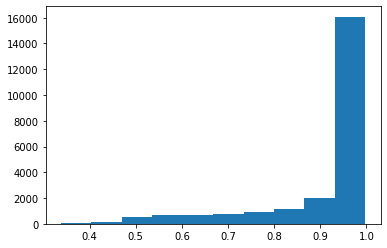

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(predicted_labels_score_list, bins=10)


In [33]:
from scipy import stats

print("percentile of 0.9: ", stats.percentileofscore(predicted_labels_score_list, 0.9))

percentile of 0.9:  24.996733876235684


In [34]:
file_name = 'confidentiality_impact'

import pickle

with open(file_name + "_predicted_class_int.txt", "wb") as f1:
    pickle.dump(predicted_labels_list, f1)
    
with open(file_name + "_predicted_labels_char.txt", "wb") as f2:
    pickle.dump(predicted_labels_char, f2)
    
with open(file_name + "_predicted_class_confidence_score.txt", "wb") as f3:
    pickle.dump(predicted_labels_score_list, f3)
 

In [35]:
with open(file_name + "_predicted_class_int.txt", "rb") as f1:
    pred_class = pickle.load(f1)
    
with open(file_name + "_predicted_labels_char.txt", "rb") as f2:
    pred_label = pickle.load(f2)
    
with open(file_name + "_predicted_class_confidence_score.txt", "rb") as f3:
    pred_confidence_score = pickle.load(f3)
    
print(len(pred_class), len(pred_label), len(pred_confidence_score))
print(pred_class, pred_label, pred_confidence_score)

22963 22963 22963
[1, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 2, 1, 1, 0, 0, 0, 0, 2, 2, 0, 0, 1, 0, 2, 0, 1, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 2, 0, 2, 0, 1, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 1, 2, 0, 1, 0, 2, 0, 1, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 1, 2, 1, 2, 1, 0, 1, 0, 1, 2, 2, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 1, 1, 1, 0, 0, 0, 1, 0, 2, 0, 0, 0, 1, 0, 2, 1, 1, 1, 2, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2, 0, 0, 1, 2, 0, 0, 2, 0, 0, 1, 0, 2, 0, 0, 1, 1, 0, 0, 0, 2, 2, 1, 2, 0, 0, 1, 0, 1, 0, 2, 0, 2, 0, 2, 0, 1, 0, 1, 0, 1, 2, 0, 0, 2, 1, 0, 2, 2, 1, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 1, 2, 0, 0, 1, 

**Explaining classification results using gradient-based saliency**

In [ ]:
import torch
from transformers import BertForSequenceClassification
from torch.utils.data import DataLoader
import torch.nn.functional as F

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = BertForSequenceClassification.from_pretrained('./bert-small-vulnerability_confidentiality_impact-classification')
model.eval()


In [ ]:
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

test_batch = next(iter(test_loader))
test_batch['input_ids']
input_ids = test_batch['input_ids']
attention_mask = test_batch['attention_mask']
labels = test_batch['encoded_labels']



outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

print(outputs.loss)
print(outputs.logits)
print(torch.max(F.softmax(outputs.logits, dim=1), dim=1))
print(labels)

In [246]:
selected_idx = 3
input_ids[selected_idx].tolist()

[101,
 1996,
 8299,
 8278,
 1997,
 1996,
 2882,
 21422,
 15384,
 2213,
 2575,
 28332,
 2186,
 2003,
 8211,
 2000,
 2019,
 14477,
 14317,
 4765,
 17872,
 6556,
 29296,
 13341,
 3081,
 19275,
 8299,
 5227,
 1012,
 2019,
 17346,
 2064,
 2224,
 2023,
 18130,
 2000,
 15389,
 5806,
 10954,
 2004,
 7117,
 2006,
 4617,
 2077,
 1015,
 1012,
 1014,
 1012,
 2539,
 1012,
 2322,
 2030,
 1999,
 20614,
 16129,
 1999,
 20786,
 7233,
 22028,
 1999,
 4617,
 2077,
 1015,
 1012,
 1014,
 1012,
 2322,
 1012,
 2459,
 1012,
 102,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [247]:
#transform each input token into an one-hot encoded representation.

from torch.autograd import Variable

input_embedding = model.get_input_embeddings()
vocab_size = input_embedding.weight.shape[0]

input_ids_one_hot = torch.nn.functional.one_hot(input_ids[selected_idx], num_classes=vocab_size)
input_ids_one_hot = input_ids_one_hot.type(torch.float)
input_ids_one_hot = Variable(input_ids_one_hot, requires_grad=True) #to allow the computation of the gradients with respect to the input 
print(input_ids_one_hot.grad)

None


In [248]:
#Calculate the input embeddings manually and pass them to the model through the inputs_embeds argument
inputs_embeds = torch.matmul(input_ids_one_hot, input_embedding.weight)
embedding_dim = input_embedding.weight.shape[1]
inputs_embeds = torch.mul(inputs_embeds, torch.cat([attention_mask[selected_idx].unsqueeze(1)]*embedding_dim, dim=1))


outputs = model(inputs_embeds=inputs_embeds.unsqueeze(0), attention_mask=attention_mask[selected_idx].unsqueeze(0), labels=labels[selected_idx].unsqueeze(0))

print("loss:", outputs.loss)
print("logits:", outputs.logits)

predicted_label = torch.max(F.softmax(outputs.logits, dim=1), dim=1)[1].item()
print("predicted label (after softmax):", predicted_label)
print("score for predicted label (after softmax):", torch.max(F.softmax(outputs.logits, dim=1), dim=1)[0].item())
print("sample true label:", labels[selected_idx])

outputs.logits[0][predicted_label].backward() #compute the gradient of the logit (predicted, the one with the highest score)
print(input_ids_one_hot.grad)                  #with respect to the input

loss: tensor(0.0064, grad_fn=<NllLossBackward>)
logits: tensor([[ 3.9755, -1.2056, -3.1501]], grad_fn=<AddmmBackward>)
predicted label (after softmax): 0
score for predicted label (after softmax): 0.9936151504516602
sample true label: tensor(0)
tensor([[-0.0060, -0.0110, -0.0017,  ..., -0.0036, -0.0111, -0.0128],
        [ 0.0004, -0.0034, -0.0009,  ..., -0.0023,  0.0030, -0.0001],
        [ 0.0136,  0.0025,  0.0173,  ..., -0.0028,  0.0124,  0.0138],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


In [249]:
connectivity_tensor = torch.linalg.norm(input_ids_one_hot.grad, dim=1)
connectivity_tensor = connectivity_tensor/torch.max(connectivity_tensor)
connectivity_tensor

tensor([0.1655, 0.0451, 0.1778, 0.2154, 0.0401, 0.0554, 0.0688, 0.1610, 0.0935,
        0.0670, 0.0472, 0.0576, 0.1498, 0.0684, 0.1297, 0.0561, 0.0515, 0.0742,
        0.1004, 0.0725, 0.1015, 0.2187, 0.8220, 0.5068, 0.1882, 0.1249, 0.1396,
        0.1128, 0.0409, 0.0486, 0.0887, 0.0383, 0.1650, 0.0486, 0.3084, 0.1558,
        1.0000, 0.6666, 0.9909, 0.2502, 0.5452, 0.1830, 0.3037, 0.1152, 0.0420,
        0.0494, 0.0730, 0.0451, 0.0580, 0.0340, 0.0521, 0.1643, 0.0580, 0.1833,
        0.3379, 0.1125, 0.8646, 0.2259, 0.2636, 0.0650, 0.1220, 0.0922, 0.0442,
        0.0594, 0.0647, 0.0293, 0.0448, 0.0251, 0.0689, 0.0415, 0.1670, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [250]:
indices_sorted_by_connectivity = torch.argsort(connectivity_tensor)
input_tokens = tokenizer.convert_ids_to_tokens(list(input_ids[selected_idx]))
top_3_indices_sorted = indices_sorted_by_connectivity[-5:].flip(dims=(0,))

print(input_tokens)
print("Most influential words by order:")
for position, score in zip(top_3_indices_sorted,
                                 connectivity_tensor[top_3_indices_sorted]):
    print(input_tokens[position.item()], "\tposition: ", position.item(), "\tconnectivity weight: ", score.item())

['[CLS]', 'the', 'http', 'interface', 'of', 'the', 'grand', '##stream', 'uc', '##m', '##6', '##200', 'series', 'is', 'vulnerable', 'to', 'an', 'una', '##uth', '##ent', '##icated', 'remote', 'sql', 'injection', 'via', 'crafted', 'http', 'request', '.', 'an', 'attacker', 'can', 'use', 'this', 'vulnerability', 'to', 'execute', 'shell', 'commands', 'as', 'root', 'on', 'versions', 'before', '1', '.', '0', '.', '19', '.', '20', 'or', 'in', '##ject', 'html', 'in', 'password', 'recovery', 'emails', 'in', 'versions', 'before', '1', '.', '0', '.', '20', '.', '17', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[

In [251]:
import re

def print_texts_with_top_influential_words_in_bold(input_text_str, input_tokens, connectivity_tensor, top_k=3):
    #input_text_str: python string coreesponding to the raw textual input
    #input_tokens: python list corresponding to the tokenized representation of the input
    #connectivity_tensor: pytorch tensor containing the norm of the gradient of the logit with respect to each input token
    #top_k: int representing the maximum number of top words to consider
    BOLD = '\033[1m'
    END = '\033[0m'
    
    output_str = input_text_str
    indices_sorted_by_connectivity = torch.argsort(connectivity_tensor)
    top_indices_sorted = indices_sorted_by_connectivity[-top_k:].flip(dims=(0,))
    
    print("Most influential words by order:")
    for position, score in zip(top_indices_sorted,
                                     connectivity_tensor[top_indices_sorted]):
        print(input_tokens[position.item()], "\tposition: ", position.item(), "\tconnectivity weight: ", score.item())
        
        if input_tokens[position.item()] in ['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']:
            continue
        
        #find the indices of every tokens containing the selected word (or token)
        indices_all_matches = [i for i, x in enumerate(input_tokens) if re.sub('^##', '', input_tokens[position.item()]) in x]
        #keep only the position intended by the model (when multiple occurences of the same word).
        #For example, if selected words occurs 3 times in the description, and the algorithms is mostly influenced by
        #second occurrence, then return 1, 3rd occurence return 2, etc
        position_of_the_intended_match = [i for i, x in enumerate(indices_all_matches) if x == position.item()]
        
        test_sub = re.escape(re.sub('^##', '', input_tokens[position.item()]))
        res = [i.start() for i in re.finditer(test_sub, output_str, re.IGNORECASE)]
        idx = position_of_the_intended_match[0]
        output_str = output_str[:res[idx]] + BOLD + output_str[res[idx]:res[idx]+len(test_sub)] + END + output_str[res[idx]+len(test_sub):]
    print(output_str)
    return output_str

In [252]:
input_text_str = test_batch['vulnerability_description'][selected_idx]
print_texts_with_top_influential_words_in_bold(input_text_str, input_tokens, connectivity_tensor, top_k=5)

Most influential words by order:
execute 	position:  36 	connectivity weight:  1.0
commands 	position:  38 	connectivity weight:  0.9909191727638245
password 	position:  56 	connectivity weight:  0.8645583987236023
sql 	position:  22 	connectivity weight:  0.8220475912094116
shell 	position:  37 	connectivity weight:  0.6665762662887573
The HTTP interface of the Grandstream UCM6200 series is vulnerable to an unauthenticated remote SQL injection via crafted HTTP request. An attacker can use this vulnerability to execute shell commands as root on versions before 1.0.19.20 or inject HTML in password recovery emails in versions before 1.0.20.17.


'The HTTP interface of the Grandstream UCM6200 series is vulnerable to an unauthenticated remote \x1bSQL\x1b injection via crafted HTTP request. An attacker can use this vulnerability to \x1bexecute\x1b \x1bshell\x1b \x1bcommands\x1b as root on versions before 1.0.19.20 or inject HTML in \x1bpassword\x1b recovery emails in versions before 1.0.20.17.'

In [253]:
test_batch['CVE_ID'][selected_idx]

'CVE-2020-5722'